In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix

In [2]:
happiness2015 = pd.read_csv("../input/world-happiness/2015.csv", encoding = "ISO-8859-1")
happiness2016 = pd.read_csv("../input/world-happiness/2016.csv", encoding = "ISO-8859-1")
happiness2017 = pd.read_csv("../input/world-happiness/2017.csv", encoding = "ISO-8859-1")

happiness2015.rename(columns={'Country': 'country'}, inplace=True)
happiness2016.rename(columns={'Country': 'country'}, inplace=True)
happiness2017.rename(columns={'Country': 'country'}, inplace=True)

In [3]:
globalterrorism = pd.read_csv("../input/gtd/globalterrorismdb_0718dist.csv", encoding = "ISO-8859-1")
globalterrorism.rename(columns={'country_txt': 'country', 'country': 'country_id'}, inplace=True)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
print(len(happiness2015.index))
print(len(globalterrorism.index))

158
181691


In [5]:
globalterrorism_happiness = globalterrorism.join(happiness2015.set_index('country'), on='country')

In [6]:
print(len(globalterrorism_happiness.index))

181691


In [7]:
def plt_cm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(cm, annot=True,annot_kws={"size": 8}, fmt='d')# font size
    plt.show()

In [8]:
def preprocess_data(df, drop=False):
    # Select tuples of countries in the MENA region only.
    df = df.loc[df['region'] == 10]

    # Select tuples starting from year 2000.
    df = df.loc[df['iyear'] >= 2000]
    
    # Drop or fill missing values.
    if drop:
        df.dropna(inplace=True)
    else: 
        # Fill numeric missing values.
        df = df.fillna(df.mean())

        # Fill categorical missing values.
        df = df.apply(lambda x : x.fillna(x.value_counts().index[0]))
    
    # Encode categorical attributes.
    encoder = LabelEncoder()

    # Categorical boolean mask.
    categorical_feature_mask = df.dtypes == object

    # Filter categorical columns using mask and turn it into a list.
    categorical_cols = df.columns[categorical_feature_mask].tolist()

    df[categorical_cols] = df[categorical_cols].apply(lambda col: encoder.fit_transform(col))
    
    # Having about 600 terrorist group name (class labels), with some groups with less
    # than 10 attacks which may cause misleading results. We reduce the number of class 
    # labels to the 5 groups with max number of attacks.

    # Get the number of attacks for each terrorist group.
    group_frequency = df['gname'].value_counts()
    violent_groups = group_frequency.keys()[0:5]

    # Keep only the 5 groups with max number of attacks.
    for index, incident in df.iterrows():
        if incident['gname'] not in violent_groups:
            df.drop(index, inplace=True)
            
    return df

In [9]:
data_dropped = preprocess_data(globalterrorism_happiness[['weaptype1','attacktype1','target1','city', 'region', 'iyear', 'gname']], True)

In [10]:
print(data_dropped.shape)
print(globalterrorism_happiness.shape)

(34184, 7)
(181691, 146)


In [11]:
globalterrorism_happiness = preprocess_data(globalterrorism_happiness)

In [12]:
globalterrorism_happiness_X_train = globalterrorism_happiness.loc[globalterrorism_happiness['iyear'] < 2017].drop(['gname'], axis=1)
globalterrorism_happiness_y_train = globalterrorism_happiness.loc[globalterrorism_happiness['iyear'] < 2017][['gname']]

globalterrorism_happiness_X_test = globalterrorism_happiness.loc[globalterrorism_happiness['iyear'] == 2017].drop(['gname'], axis=1)
globalterrorism_happiness_y_test = globalterrorism_happiness.loc[globalterrorism_happiness['iyear'] == 2017][['gname']]

In [30]:
print(globalterrorism_happiness_y_train['gname'].nunique())

SyntaxError: invalid syntax (<ipython-input-30-4f7106842a29>, line 1)

In [13]:
data_dropped_X_train = data_dropped.loc[data_dropped['iyear'] < 2017].drop(columns=['region', 'gname'])
data_dropped_y_train = data_dropped.loc[data_dropped['iyear'] < 2017][['gname']]

data_dropped_X_test = data_dropped.loc[data_dropped['iyear'] == 2017].drop(columns=['region', 'gname'])
data_dropped_y_test = data_dropped.loc[data_dropped['iyear'] == 2017][['gname']]

In [14]:
# Feature selection.

globalterrorism_X_train = globalterrorism_happiness_X_train#[['weaptype1','attacktype1','target1','city', 'country', 'suicide']]
globalterrorism_X_test = globalterrorism_happiness_X_test#[['weaptype1','attacktype1','target1','city', 'country', 'suicide']]

globalterrorism_happiness_X_train = globalterrorism_happiness_X_train[['weaptype1','attacktype1','target1','city', 'Happiness Score','Freedom']]
globalterrorism_happiness_X_test = globalterrorism_happiness_X_test[['weaptype1','attacktype1','target1','city', 'Happiness Score','Freedom']]

In [20]:
# kNN classifier.
def knn_classifier(X_train, y_train, X_test, y_test):
    scores = []
    n_range = range(1, 1000, 100)
    for n in n_range:
        print(n)
        neigh = KNeighborsClassifier(n_neighbors=n)
        neigh.fit(X_train, np.ravel(y_train, len(y_train.index)))
        y_predict = neigh.predict(X_test)
        scores.append(f1_score(y_test, y_predict, average='micro'))
        
    plt.plot(scores)
    plt.show()
    plt_cm(y_test, y_predict)
    return scores

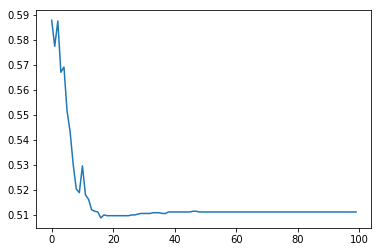

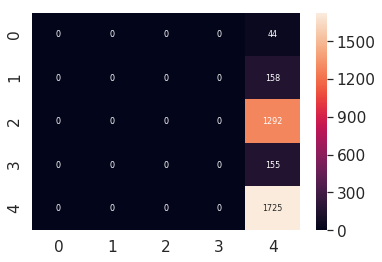

KNN on data with dropped tuples score: 0.5877296976882039


In [16]:
# Dropped data.
score = np.max(knn_classifier(data_dropped_X_train, data_dropped_y_train, data_dropped_X_test, data_dropped_y_test))
print("KNN on data with dropped tuples score: " + str(score))

1
101
201
301
401
501
601
701
801
901


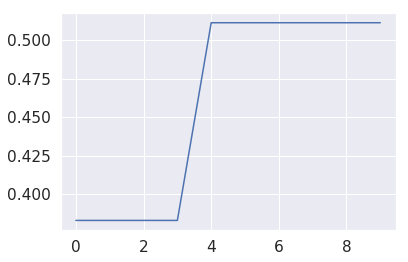

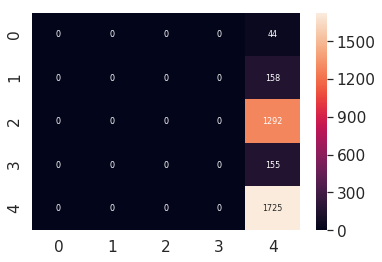

KNN on data [GTD] with filled tuples score: 0.511262596324837
1
101
201
301
401
501
601
701
801
901


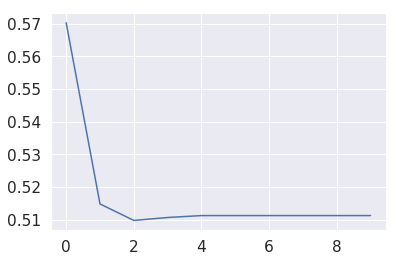

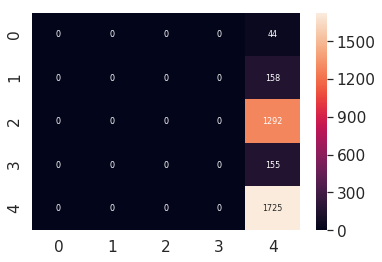

KNN on data [GTD + WHR] with filled tuples score: 0.5702430349733254


In [21]:
# GTD only.
score = np.max(knn_classifier(globalterrorism_X_train, globalterrorism_happiness_y_train, globalterrorism_X_test, globalterrorism_happiness_y_test))
print("KNN on data [GTD] with filled tuples score: " + str(score))

# GTD and WHR combined.
score = np.max(knn_classifier(globalterrorism_happiness_X_train, globalterrorism_happiness_y_train, globalterrorism_happiness_X_test, globalterrorism_happiness_y_test))
print("KNN on data [GTD + WHR] with filled tuples score: " + str(score))

In [23]:
def decisiontree_classifier(X_train, y_train, X_test, y_test):
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train, np.ravel(y_train, len(y_train.index)))
    y_predict = clf.predict(X_test)
    score = f1_score(y_test, y_predict, average='micro')
    
    print(score)
    plt_cm(y_test, y_predict)
    return score

In [ ]:
# Dropped data.
score = decisiontree_classifier(data_dropped_X_train, data_dropped_y_train, data_dropped_X_test, data_dropped_y_test)
print("Decision tree on data with dropped tuples score: " + str(score))

0.9961470065204505


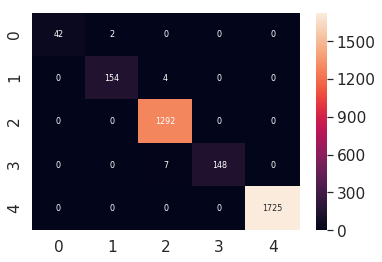

0.7030231179608772


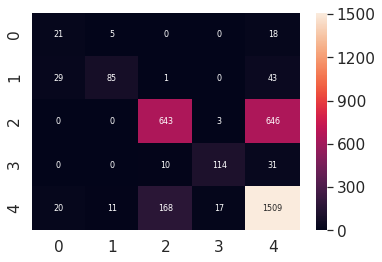

0.7030231179608772

In [24]:
# GTD only.
decisiontree_classifier(globalterrorism_X_train, globalterrorism_happiness_y_train, globalterrorism_X_test, globalterrorism_happiness_y_test)

# GTD and WHR combined.
decisiontree_classifier(globalterrorism_happiness_X_train, globalterrorism_happiness_y_train, globalterrorism_happiness_X_test, globalterrorism_happiness_y_test)

In [ ]:
def naivebayes_classifier(X_train, y_train, X_test, y_test):
    clf = GaussianNB()
    clf = clf.fit(X_train, np.ravel(y_train, len(y_train.index)))
    y_predict = clf.predict(X_test)
    score = f1_score(y_test, y_predict, average='micro')
    
    print(score)
    plt_cm(y_test, y_predict)

In [ ]:
# GTD only.
naivebayes_classifier(globalterrorism_X_train, globalterrorism_happiness_y_train, globalterrorism_X_test, globalterrorism_happiness_y_test)

# GTD and WHR combined.
naivebayes_classifier(globalterrorism_happiness_X_train, globalterrorism_happiness_y_train, globalterrorism_happiness_X_test, globalterrorism_happiness_y_test)

In [ ]:
def svm_classifier(X_train, y_train, X_test, y_test):
    clf = SVC()
    clf = clf.fit(X_train, np.ravel(y_train, len(y_train.index)))
    y_predict = clf.predict(X_test)
    score = f1_score(y_test, y_predict, average='micro')
    
    print(score)
    plt_cm(y_test, y_predict)

In [ ]:
# GTD only.
svm_classifier(globalterrorism_X_train, globalterrorism_happiness_y_train, globalterrorism_X_test, globalterrorism_happiness_y_test)

# GTD and WHR combined.
svm_classifier(globalterrorism_happiness_X_train, globalterrorism_happiness_y_train, globalterrorism_happiness_X_test, globalterrorism_happiness_y_test)

In [ ]:
def adaboost_classifier(X_train, y_train, X_test, y_test):
    scores = []
    estimators = range(1, 100)

    for n in estimators:
        clf = AdaBoostClassifier(n_estimators=n, random_state=0)
        clf = clf.fit(X_train, np.ravel(y_train, len(y_train.index)))
        y_predict = clf.predict(X_test)
        scores.append(f1_score(y_test, y_predict, average='micro'))
    
    print(np.max(scores))
    plt.plot(estimators, scores)
    plt.show()
    plt_cm(y_test, y_predict)

In [ ]:
# GTD only.
adaboost_classifier(globalterrorism_X_train, globalterrorism_happiness_y_train, globalterrorism_X_test, globalterrorism_happiness_y_test)

# GTD and WHR combined.
adaboost_classifier(globalterrorism_happiness_X_train, globalterrorism_happiness_y_train, globalterrorism_happiness_X_test, globalterrorism_happiness_y_test)

In [25]:
def randomforest_classifier(X_train, y_train, X_test, y_test):
    scores = []
    estimators = range(1, 1000, 100)

    for n in estimators:
        clf = RandomForestClassifier(n_estimators=n, random_state=0)
        clf = clf.fit(X_train, np.ravel(y_train, len(y_train.index)))
        y_predict = clf.predict(X_test)
        scores.append(f1_score(y_test, y_predict, average='micro'))
        
    plt.plot(estimators, scores)
    plt.show()
    print(np.max(scores))
    plt_cm(y_test, y_predict)

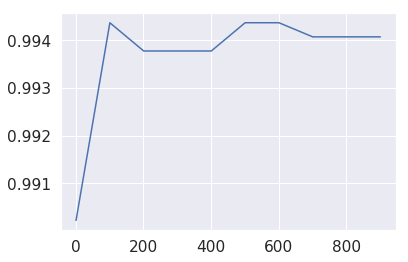

0.9943687018375815


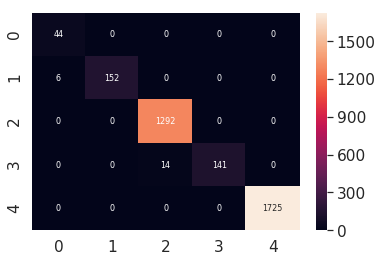

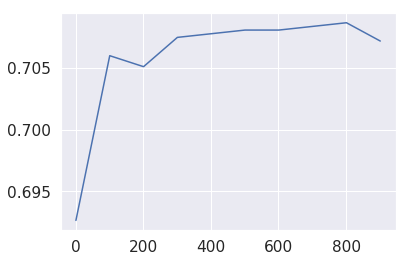

0.7086544161232958


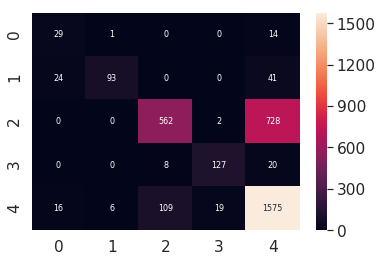

In [26]:
# GTD only.
randomforest_classifier(globalterrorism_X_train, globalterrorism_happiness_y_train, globalterrorism_X_test, globalterrorism_happiness_y_test)

# GTD and WHR combined.
randomforest_classifier(globalterrorism_happiness_X_train, globalterrorism_happiness_y_train, globalterrorism_happiness_X_test, globalterrorism_happiness_y_test)

In [ ]:
def qda_classifier(X_train, y_train, X_test, y_test):
    clf = QuadraticDiscriminantAnalysis()
    clf = clf.fit(X_train, np.ravel(y_train, len(y_train.index)))
    y_predict = clf.predict(X_test)
    score = f1_score(y_test, y_predict, average='micro')
    
    print(score)
    plt_cm(y_test, y_predict)

In [ ]:
# GTD only.
qda_classifier(globalterrorism_X_train, globalterrorism_happiness_y_train, globalterrorism_X_test, globalterrorism_happiness_y_test)

# GTD and WHR combined.
qda_classifier(globalterrorism_happiness_X_train, globalterrorism_happiness_y_train, globalterrorism_happiness_X_test, globalterrorism_happiness_y_test)